In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import seaborn as sns
import pickle
import re
from collections import Counter

In [3]:
# Biopython modules
# pip install biopython
import Bio
import Bio.Seq
import Bio.SeqRecord
from Bio import SeqIO

### iBAQ calculation

In [3]:
# Set up a list of seqIO objects to save our sequences for the next step

sequences = [] 

for seq_record in SeqIO.parse("UP000005640_960601052023.fasta", "fasta"):
    sequences.append(seq_record)

In [4]:
len(sequences)

20594

In [5]:
# make master list all_seq = all possible peptides from fasta file that are 7-30 aa long including all cleavages + 1 missed cleavage
all_seq = []
for x in range(0,len(sequences)):
    tmp_lst = []
    tmp=re.split(r'(?<=[R|K])', str(sequences[x].seq))
    for i in range(1,len(tmp)):
        if len(tmp[i])>0:
            tmp_lst.append(tmp[i-1]+tmp[i])
    tmp_lst.extend(tmp)
    for seq in tmp_lst:
        if 6 < len(seq) < 31:
            all_seq.append(seq)

In [6]:
# make list of peptides with value count > 1 (ie non-unique) 
c=Counter(all_seq)

In [7]:
nonuniqpep_lst=[k for k, v in c.items() if v > 1]

In [9]:
# make dict of each protein and corresponding possible unique peptides 7-30 aa in length
len_dict = {}
for x in range(0,len(sequences)):
    tmp_lst = []
    tmp=re.split(r'(?<=[R|K])', str(sequences[x].seq))
    for i in range(1,len(tmp)):
        if len(tmp[i])>0:
            tmp_lst.append(tmp[i-1]+tmp[i])
    tmp_lst.extend(tmp)
    sel_seq = []
    for seq in tmp_lst:
        if 6 < len(seq) < 31:
            if seq not in nonuniqpep_lst:
                sel_seq.append(seq)
    len_dict[sequences[x].id.split('|')[2]] = len(sel_seq)

### DIANN+iBAQ

In [21]:
# upload pr_matrix
df = pd.read_table(r'C:\\Users\\momenzadeha\\Documents\DIA-NN\outputs\libfreelib\libfreelib.pr_matrix.tsv')
print(df.shape)

(9404, 63)


In [13]:
# drop proteins with multiple members 
df = df.drop(df[df['Protein.Names'].str.contains(';')].index)

In [14]:
# fill Na's with zero
df.fillna(0, inplace=True)

In [16]:
# remove rows with all zeroes in df
df=df.loc[~(df==0).all(axis=1)]

In [22]:
df.drop(['Protein.Ids','Genes','Precursor.Charge', 'First.Protein.Description', 'Proteotypic', 'Stripped.Sequence','Modified.Sequence',
         'Protein.Group'],axis=1,inplace=True)

In [23]:
# remove peptide 'DEELDQLKR2' that maps to MYH4 (differs from MYH2 by the assignment of L versus I)
df.drop([943], inplace=True)

In [25]:
# iBAQ: loop through each unique protein, sum the peptides, add those summed values to a new df, divide by # possible peptides for that protein(len_dict)
proteins = df['Protein.Names'].unique()
tmplist = []
for x in proteins:
    if ';' not in x:
        tmpdf = df[df['Protein.Names']==x]
        tmpser = tmpdf.loc[:,tmpdf.columns[2:]].sum()
        tmplist.append(tmpser.to_frame(name=x).T/len_dict[x])
newdf=pd.concat(tmplist)

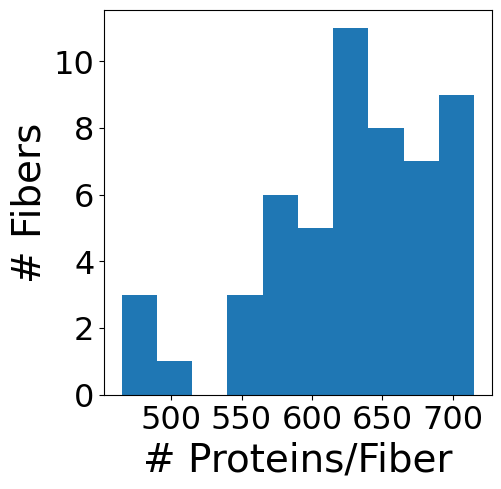

In [26]:
plt.rcParams['figure.figsize'] = 5,5
plt.hist(newdf[newdf>1].count())
plt.xlabel('# Proteins/Fiber',fontsize=28)
plt.ylabel('# Fibers',fontsize=28)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.savefig('plots/1B.svg', bbox_inches='tight')

In [28]:
# mean of proteins/fiber
newdf[newdf>1].count().mean()

628.811320754717

In [29]:
# SD
newdf[newdf>1].count().std()

61.9516115776516

In [30]:
# rename the columns
wells = [x.split('_')[-5] for x in newdf.columns[0:].values]

In [32]:
newdf.columns = wells

In [33]:
diann_prot=newdf.copy()

In [35]:
# find most abundant protein
tmplist=[]
for x in diann_prot.columns:
    #print(diann_prot[x].sort_values(ascending=False).iloc[:5,])
    tmplist.append(diann_prot[x].sort_values(ascending=False).iloc[:1,])

In [36]:
pd.DataFrame(tmplist).describe().iloc[0,:].sort_values(ascending=False)

ACTS_HUMAN    53.0
Name: count, dtype: float64

In [37]:
# save ibaq calculated quantities
diann_prot.to_csv(r'/Users/momenzadeha/Documents/DIA-NN/diann_prot.csv')

In [38]:
# extract all MYH rows
myh_df_ibaq=diann_prot[diann_prot.index.str.contains('MYH')]

In [40]:
# find fraction of each MYH intensity to total MYH per fiber
myh_pcts_ibaq=myh_df_ibaq.div(myh_df_ibaq.sum())

In [41]:
# sort by MYH2 
myh_pcts_ibaq_sortedmyh=myh_pcts_ibaq.sort_values(by='MYH2_HUMAN', axis=1)

In [42]:
# save myh fractions as supp table 2
myh_pcts_ibaq_sortedmyh.to_csv(r'/Users/momenzadeha/Documents/DIA-NN/Supplementary Table 2.csv')

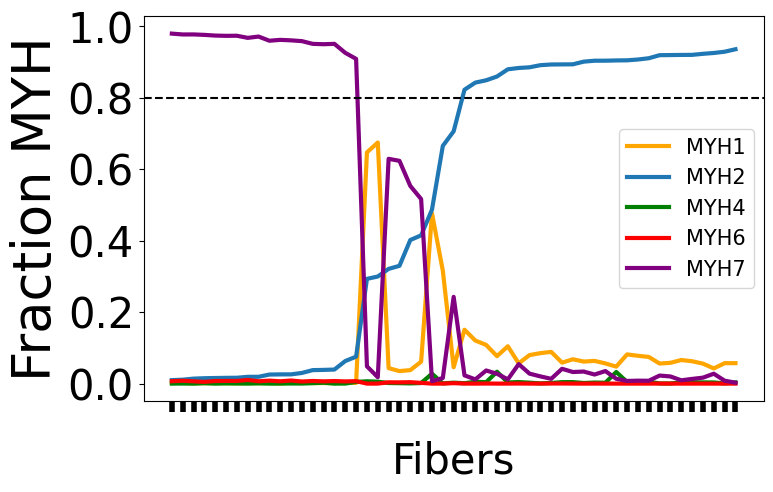

In [48]:
# plot ibaq myh fractions sorted by MYH@
m = myh_pcts_ibaq.sort_values(by='MYH2_HUMAN', axis=1)
plt.rcParams['figure.figsize'] = 10,5
fig = plt.figure()
ax = plt.subplot(111)

l1, = plt.plot(m.loc['MYH1_HUMAN'], label='MYH1',linewidth=3,color='orange')
l2, = plt.plot(m.loc['MYH2_HUMAN'], label='MYH2',linewidth=3,color='#1f77b4')
l3, = plt.plot(m.loc['MYH4_HUMAN'], label='MYH4',linewidth=3,color='green')
l4, = plt.plot(m.loc['MYH6_HUMAN'], label='MYH6',linewidth=3,color='red')
l5, = plt.plot(m.loc['MYH7_HUMAN'], label='MYH7',linewidth=3,color='purple')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.axhline(y = 0.8, color = 'black', linestyle = 'dashed')
ax.legend(loc='center left', bbox_to_anchor=(0.75,0.5),fontsize=15)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xticks(fontsize=30)
plt.ylabel('Fraction MYH', fontsize=38)
plt.xlabel('Fibers', fontsize=30)
ax.tick_params(labelbottom=False)
ax.tick_params(axis='x',width=4, length=8)
ax.xaxis.labelpad = 20

plt.savefig('plots/2C.svg', bbox_inches='tight')

In [53]:
# plot # MYH1,2,4,7 
binstouse = np.arange(0,1,0.025)

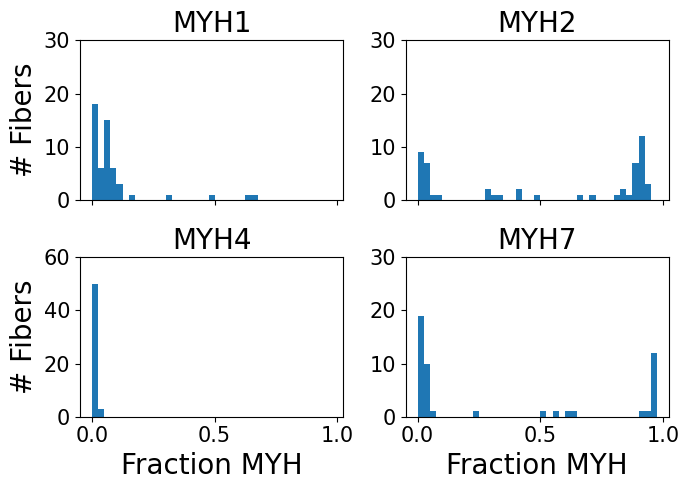

In [66]:
plt.rcParams['figure.figsize']= 7,5
fig, axs = plt.subplots(2,2, sharex=True)

axs[0,0].hist(myh_pcts_ibaq.loc['MYH1_HUMAN'], bins=binstouse)
axs[0,1].hist(myh_pcts_ibaq.loc['MYH2_HUMAN'], bins=binstouse)
axs[1,0].hist(myh_pcts_ibaq.loc['MYH4_HUMAN'], bins=binstouse)
axs[1,1].hist(myh_pcts_ibaq.loc['MYH7_HUMAN'], bins=binstouse)

axs[0,0].set_title('MYH1',fontsize=20)
axs[0,1].set_title('MYH2',fontsize=20)
axs[1,0].set_title('MYH4',fontsize=20)
axs[1,1].set_title('MYH7',fontsize=20)

axs[0,0].set_ylabel('# Fibers',fontsize=20)
axs[1,0].set_xlabel('Fraction MYH',fontsize=20)
axs[1,0].set_ylabel('# Fibers',fontsize=20)
axs[1,1].set_xlabel('Fraction MYH',fontsize=20)
axs[0,0].tick_params(axis='both', which='both', labelsize=15)
axs[0,0].set_ylim(0, 30)
axs[0,1].tick_params(axis='both', which='both', labelsize=15)
axs[0,1].set_ylim(0, 30)
axs[1,0].tick_params(axis='both', which='both', labelsize=15)
axs[1,0].set_ylim(0,60)
axs[1,1].tick_params(axis='both', which='both', labelsize=15)
axs[1,1].set_ylim(0, 30)
fig.tight_layout() 
ax.set_facecolor('white')
plt.savefig('plots/2D.svg')

In [49]:
# normalize to ACTS/fiber
tmplist = []
for x in range(0,len(diann_prot.columns)):
    data=diann_prot.iloc[:,x]/diann_prot.loc[['ACTS_HUMAN']].iloc[:,x][0]
    tmplist.append(data)
diann_prot_norm=pd.concat(tmplist, axis=1)

In [50]:
# all ACTS quantities should be 1
diann_prot_norm.loc[['ACTS_HUMAN']]

,B6,B17,B19,B22,C7,C9,C10,C13,C14,C23,...,K11,K12,K14,K15,K17,K19,K20,K21,K23,K24
ACTS_HUMAN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [51]:
# save ibaq/actin norm quantities
diann_prot_norm.to_csv(r'/Users/momenzadeha/Documents/DIA-NN/diann_prot_norm.csv')

### MaxLFQ

In [69]:
# upload pg matrix (protein  group output from DIA-NN)
df = pd.read_table(r'C:\\Users\\momenzadeha\\Documents\DIA-NN\outputs\libfreelib\libfreelib.pg_matrix.tsv') 

In [70]:
# drop proteins with multiple members 
df = df.drop(df[df['Protein.Names'].str.contains(';')].index)

In [71]:
# fill Na's with zero
df.fillna(0, inplace=True)

In [72]:
# remove rows with all zeroes in df
df=df.loc[~(df==0).all(axis=1)]

In [73]:
df.drop(['Protein.Group', 'Protein.Ids', 'Genes', 'First.Protein.Description'],axis=1, inplace=True)
df.set_index('Protein.Names', inplace=True)

In [74]:
# rename the columns 
wells = [x.split('_')[-5] for x in df.columns[0:].values]

In [76]:
df.columns = wells

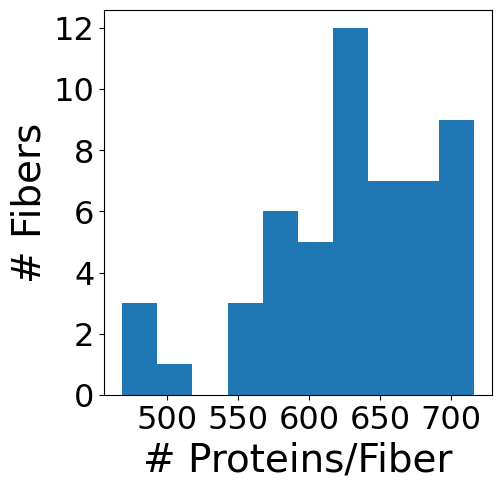

In [82]:
plt.rcParams['figure.figsize'] = 5,5
plt.hist(df[df>1].count())
plt.xlabel('# Proteins/Fiber',fontsize=28)
plt.ylabel('# Fibers',fontsize=28)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [83]:
# mean of proteins/fiber
df[df>1].count().mean()

630.7735849056604

In [84]:
# SD
df[df>1].count().std()

61.22833730246464

In [85]:
# find most abundant protein
tmplist=[]
for x in df.columns:
    #print(df[x].sort_values(ascending=False).iloc[:5,])
    tmplist.append(df[x].sort_values(ascending=False).iloc[:1,])

In [86]:
maxlfq_prot=df.copy()

In [89]:
# save MaxLFQ quantities
maxlfq_prot.to_csv('maxlfq_prot.csv')

In [92]:
# extract all MYH rows
myh_df_maxlfq=maxlfq_prot.filter(like='MYH', axis=0)

In [93]:
# find fraction of each MYH intensity to total MYH per fiber
myh_pcts_maxlfq=myh_df_maxlfq.div(myh_df_maxlfq.sum())

In [94]:
# sort by MYH2
myh_pcts_maxlfq_sortedmyh2=myh_pcts_maxlfq.sort_values(by='MYH2_HUMAN', axis=1)

In [95]:
# save myh fractions as supp table 3
myh_pcts_maxlfq_sortedmyh2.to_csv(r'/Users/momenzadeha/Documents/DIA-NN/Supplementary Table 3.csv')

In [96]:
# normalize to ACTS/fiber
tmplist = []
for x in range(0,len(maxlfq_prot.columns)):
    data=maxlfq_prot.iloc[:,x]/maxlfq_prot.loc[['ACTS_HUMAN']].iloc[:,x][0]
    tmplist.append(data)
maxlfq_norm=pd.concat(tmplist, axis=1)

In [97]:
# make sure acts row is all 1
maxlfq_norm.loc[['ACTS_HUMAN']]

,B6,B17,B19,B22,C7,C9,C10,C13,C14,C23,...,K11,K12,K14,K15,K17,K19,K20,K21,K23,K24
Protein.Names,,,,,,,,,,,,,,,,,,,,,
ACTS_HUMAN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


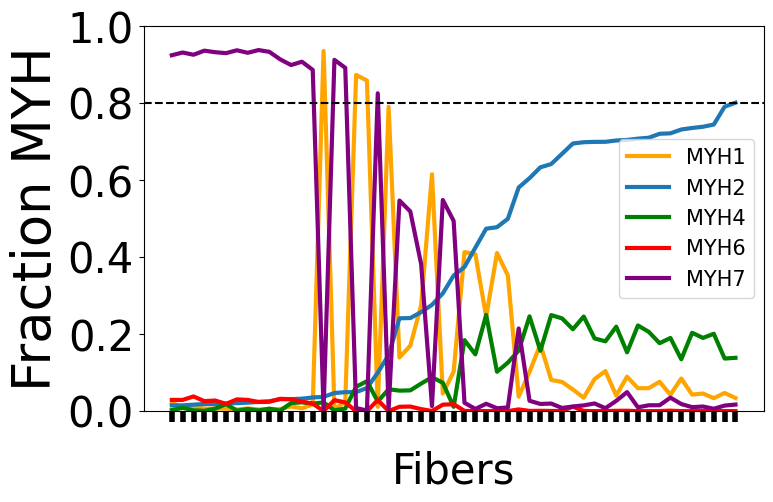

In [100]:
m = myh_pcts_maxlfq.sort_values(by='MYH2_HUMAN', axis=1)
plt.rcParams['figure.figsize'] = 10,5
fig = plt.figure()
ax = plt.subplot(111)

l1, = plt.plot(m.loc['MYH1_HUMAN'], label='MYH1', linewidth=3, color='orange')
l2, = plt.plot(m.loc['MYH2_HUMAN'], label='MYH2', linewidth=3,color='#1f77b4')
l3, = plt.plot(m.loc['MYH4_HUMAN'], label='MYH4', linewidth=3,color='green')
l4, = plt.plot(m.loc['MYH6_HUMAN'], label='MYH6', linewidth=3,color='red')
l5, = plt.plot(m.loc['MYH7_HUMAN'], label='MYH7', linewidth=3,color='purple')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.axhline(y = 0.8, color = 'black', linestyle = 'dashed')
ax.legend(loc='center left', bbox_to_anchor=(0.75,0.5),fontsize=15)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xticks(fontsize=30)
plt.ylabel('Fraction MYH', fontsize=38)
plt.xlabel('Fibers', fontsize=30)
ax.tick_params(labelbottom=False)
ax.tick_params(axis='x',width=4, length=8)
ax.xaxis.labelpad = 20
ax.set_ylim(0,1)

plt.savefig('plots/2A.svg', bbox_inches='tight')

In [602]:
binstouse = np.arange(0,1,0.025)

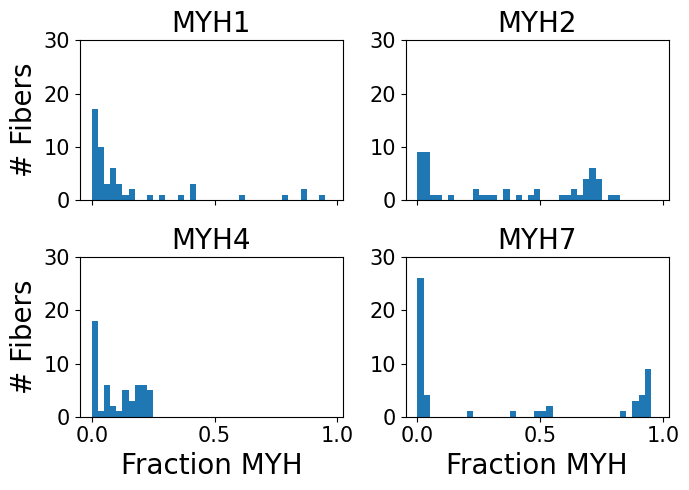

In [102]:
plt.rcParams['figure.figsize']= 7,5
fig, axs = plt.subplots(2,2, sharex=True)

axs[0,0].hist(myh_pcts_maxlfq.loc['MYH1_HUMAN'], bins=binstouse)
axs[0,1].hist(myh_pcts_maxlfq.loc['MYH2_HUMAN'], bins=binstouse)
axs[1,0].hist(myh_pcts_maxlfq.loc['MYH4_HUMAN'], bins=binstouse)
axs[1,1].hist(myh_pcts_maxlfq.loc['MYH7_HUMAN'], bins=binstouse)

axs[0,0].set_title('MYH1',fontsize=20)
axs[0,1].set_title('MYH2',fontsize=20)
axs[1,0].set_title('MYH4',fontsize=20)
axs[1,1].set_title('MYH7',fontsize=20)

plt.xticks(fontsize=17)
plt.yticks(fontsize=20)
axs[0,0].set_ylabel('# Fibers',fontsize=20)
axs[1,0].set_xlabel('Fraction MYH',fontsize=20)
axs[1,0].set_ylabel('# Fibers',fontsize=20)
axs[1,1].set_xlabel('Fraction MYH',fontsize=20)
axs[0,0].tick_params(axis='both', which='both', labelsize=15)
axs[0,0].set_ylim(0, 30)
axs[0,1].tick_params(axis='both', which='both', labelsize=15)
axs[0,1].set_ylim(0, 30)
axs[1,0].tick_params(axis='both', which='both', labelsize=15)
axs[1,0].set_ylim(0, 30)
axs[1,1].tick_params(axis='both', which='both', labelsize=15)
axs[1,1].set_ylim(0, 30)
fig.tight_layout() 
plt.savefig('plots/2B.svg')

### MYH4 heatmaps

In [40]:
df = pd.read_table(r'C:\\Users\\momenzadeha\\Documents\DIA-NN\outputs\libfreelib\libfreelib.pr_matrix.tsv')
print(df.shape)

(9404, 63)


In [41]:
# drop proteins with multiple members 
df = df.drop(df[df['Protein.Names'].str.contains(';')].index)

In [42]:
df.drop(['Protein.Group', 'Protein.Ids', 'Protein.Names', 'First.Protein.Description', 
         'Proteotypic','Stripped.Sequence','Modified.Sequence','Precursor.Charge'],axis=1, inplace=True)
df.set_index('Genes', inplace=True)

In [43]:
# fill Na's with zero
df.fillna(0, inplace=True)

In [44]:
# remove rows with all zeroes in df
df=df.loc[~(df==0).all(axis=1)]

In [45]:
# rename the columns
wells = [x.split('_')[-5] for x in df.columns[1:].values]
wells = ['precursor']+wells

In [46]:
df.columns = wells

In [47]:
df=df.reset_index()

In [48]:
sns.set(rc={'figure.figsize':(27,2)})

In [49]:
df.set_index('Genes', inplace=True)

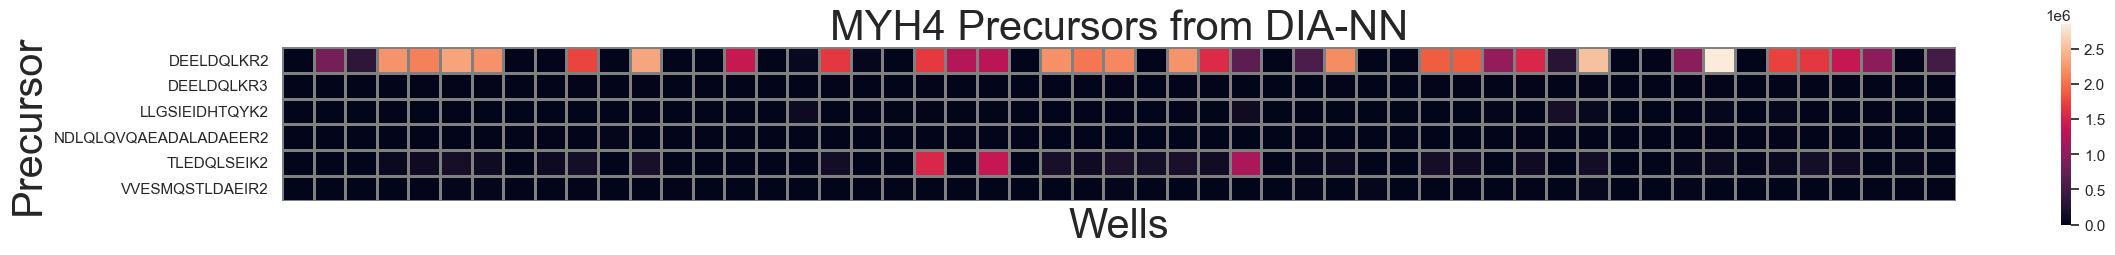

In [50]:
tmpdf=df.loc['MYH4']
tmpdf.set_index('precursor', inplace=True)
ax=sns.heatmap(tmpdf.iloc[:,:],cbar_kws={"shrink": 1.3},linewidths=0.8,linecolor="grey")


plt.xlabel('Wells', fontsize=30)
plt.ylabel('Precursor', fontsize=30)

plt.title('MYH4 Precursors from DIA-NN',fontsize=30)
ax.tick_params(labelbottom=False)
plt.savefig('plots/supp1C.svg',bbox_inches = "tight")

In [61]:
tmpdf.drop(['DEELDQLKR2'],inplace=True)

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_66888\3616018141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmpdf.drop(['DEELDQLKR2'],inplace=True)


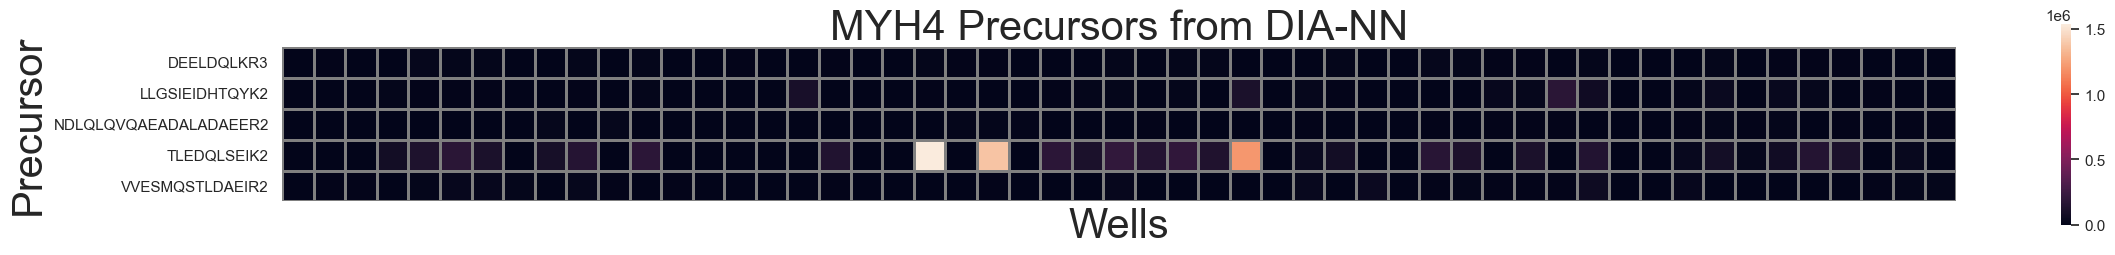

In [62]:
ax=sns.heatmap(tmpdf.iloc[:,:],cbar_kws={"shrink": 1.3},linewidths=0.8,linecolor="grey")


plt.xlabel('Wells', fontsize=30)
plt.ylabel('Precursor', fontsize=30)

plt.title('MYH4 Precursors from DIA-NN',fontsize=30)
ax.tick_params(labelbottom=False)